In [255]:
import numpy as np  # Importa la biblioteca NumPy bajo el alias 'np' para realizar cálculos numéricos.
from shapely.ops import split  # Importa la función 'split' desde Shapely para realizar operaciones de división en geometrías.
import geopandas as gpd  # Importa la biblioteca GeoPandas bajo el alias 'gpd' para el análisis de datos geoespaciales.
from shapely.geometry import MultiPolygon, Polygon, LineString  # Importa varios tipos de geometrías desde Shapely para representar formas geométricas en el espacio.
import ee
import requests
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [232]:
# Ruta del archivo de datos geoespaciales (Shapefile) que se va a leer.
geo_filepath = "shapefiles/nombre_shapefile.shp"

In [233]:
# Lee el archivo Shapefile especificado en 'geo_filepath' y lo carga en un GeoDataFrame (GeoDF).
GeoDF = gpd.read_file(geo_filepath)


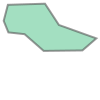

In [234]:
# Selecciona una geometría aleatoria del GeoDataFrame 'GeoDF' y almacénala en la variable 'G'.

G = np.random.choice(GeoDF.geometry.values)
G

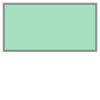

In [235]:
# Calcula la envolvente (rectángulo delimitador) de la geometría almacenada en 'G' y almacena el resultado en 'Rectangle'.
Rectangle = G.envelope
Rectangle

In [236]:
# Longitud del lado de la celda
side_length = 0.02

# Obtiene las coordenadas de la envolvente del rectángulo y las almacena en 'rect_coords'
rect_coords = np.array(Rectangle.boundary.coords.xy)

# Extrae las listas de coordenadas x e y de 'rect_coords'
y_list = rect_coords[1]
x_list = rect_coords[0]

# Calcula los valores mínimos y máximos de las coordenadas y para obtener la altura del rectángulo
y1 = min(y_list)
y2 = max(y_list)

# Calcula los valores mínimos y máximos de las coordenadas x para obtener el ancho del rectángulo
x1 = min(x_list)
x2 = max(x_list)

# Calcula el ancho y la altura del rectángulo
width = x2 - x1
height = y2 - y1

# Calcula el número de celdas en la dirección x e y, redondeando al entero más cercano
xcells = int(np.round(width / side_length))
ycells = int(np.round(height / side_length))

# Crea una serie de índices igualmente espaciados en las direcciones x e y
yindices = np.linspace(y1, y2, ycells + 1)
xindices = np.linspace(x1, x2, xcells + 1)
width,height


(0.07990837097187864, 0.04072795294179343)

In [237]:
# Crea una lista de líneas horizontales que atraviesan el rectángulo delimitador en direcciones verticales.
horizontal_splitters = [
    LineString([(x, yindices[0]), (x, yindices[-1])]) for x in xindices
]

# Imprime la lista de líneas horizontales.
horizontal_splitters

[<LINESTRING (-73.156 -36.742, -73.156 -36.702)>,
 <LINESTRING (-73.136 -36.742, -73.136 -36.702)>,
 <LINESTRING (-73.117 -36.742, -73.117 -36.702)>,
 <LINESTRING (-73.097 -36.742, -73.097 -36.702)>,
 <LINESTRING (-73.077 -36.742, -73.077 -36.702)>]

In [238]:
# Crea una lista de líneas verticales que atraviesan el rectángulo delimitador en direcciones horizontales.
vertical_splitters = [
    LineString([(xindices[0], y), (xindices[-1], y)]) for y in yindices
]

# Imprime la lista de líneas verticales.
vertical_splitters

[<LINESTRING (-73.156 -36.742, -73.077 -36.742)>,
 <LINESTRING (-73.156 -36.722, -73.077 -36.722)>,
 <LINESTRING (-73.156 -36.702, -73.077 -36.702)>]

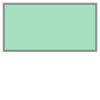

In [239]:
# Asigna la geometría del rectángulo delimitador original a la variable 'result'.
result = Rectangle

# Imprime 'result', que ahora contiene la misma geometría que 'Rectangle'.
result

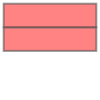

In [240]:
# Itera sobre la lista de líneas verticales 'vertical_splitters' y divide la geometría 'result' en múltiples polígonos.
for splitter in vertical_splitters:
    result = MultiPolygon(split(result, splitter))

# Imprime 'result', que ahora contiene los polígonos resultantes después de la división.
result

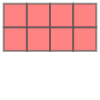

In [241]:
# Itera sobre la lista de líneas horizontales 'horizontal_splitters' y divide la geometría 'result' en múltiples polígonos.
for splitter in horizontal_splitters:
    result = MultiPolygon(split(result, splitter))

# Imprime 'result', que ahora contiene los polígonos resultantes después de la división horizontal y vertical.
result


In [242]:
# Extrae los polígonos individuales del resultado final 'result' y los almacena en la lista 'square_polygons'.
square_polygons = list(result.geoms)
len(square_polygons)


8

In [243]:
# Crea un GeoDataFrame a partir de la lista de polígonos 'square_polygons'.
df = gpd.GeoDataFrame(square_polygons)


In [244]:
# Crea un nuevo GeoDataFrame a partir de la lista de polígonos 'square_polygons'.
SquareGeoDF  = gpd.GeoDataFrame(square_polygons).rename(columns={0: "geometry"})

In [245]:
# Crea un nuevo GeoDataFrame a partir de la lista de polígonos 'square_polygons'.
SquareGeoDF = gpd.GeoDataFrame(square_polygons)

# Establece la geometría del GeoDataFrame en la primera columna (índice 0) de los datos.
SquareGeoDF = SquareGeoDF.set_geometry(0)


In [246]:
# Extrae las geometrías de 'SquareGeoDF' que se intersectan con la geometría 'G' y las almacena en 'Geoms'.
Geoms = SquareGeoDF[SquareGeoDF.intersects(G)].geometry.values

# Define una variable 'shape' con el valor "square".
shape = "square"

# Define una variable 'thresh' con el valor 0.9.
thresh = 0.2

In [247]:
# Si la variable 'shape' es igual a "rhombus", realiza las siguientes operaciones.
if shape == "rhombus":
    # Aplica una función 'rhombus(g)' a cada geometría en 'Geoms' y almacena los resultados en 'Geoms'.
    #Geoms = [rhombus(g) for g in Geoms]
    # Filtra las geometrías en 'Geoms' que cumplen con una condición de área y las almacena en 'geoms'.
    geoms = [g for g in Geoms if ((g.intersection(G)).area / g.area) >= thresh]

# Si la variable 'shape' es igual a "square", realiza las siguientes operaciones.
elif shape == "square":
   
    # Filtra las geometrías en 'Geoms' que cumplen con una condición de área y las almacena en 'geoms'.
    geoms = [g for g in Geoms if ((g.intersection(G)).area / g.area) >= thresh]

geoms
len(geoms)

6

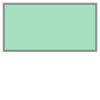

In [248]:
Rectangle

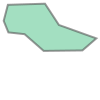

In [249]:
G

In [250]:
def crear_archivo_shapefile(geometry, nombre):
    # Convierte la lista de listas en una lista de tuplas

    #print(geometry)
    polygon = Polygon(tuple(geometry))

    # Crea un GeoDataFrame con la geometría
    gdf = gpd.GeoDataFrame({'geometry': [polygon]})


    directorio = './shapefilesprueba/'+ nombre+'/'
    
    if not os.path.exists(directorio):
    # Si no existe, crearlo
        os.makedirs(directorio)


    # Define la ruta donde deseas guardar el archivo shapefile
    ruta_guardar = './shapefilesprueba/'+ nombre+'/' + nombre +'.shp'

    # Guarda el GeoDataFrame como un archivo shapefile
    gdf.to_file(ruta_guardar)

    #print(f'Shapefile guardado en: {ruta_guardar}')
    return ruta_guardar

In [251]:


print(type(geoms))
# Supongamos que ya tienes 'geoms' definido
grid = gpd.GeoDataFrame({'geometry': geoms})

index = 1
for sq in geoms:
    xx, yy = sq.exterior.coords.xy
    x = xx.tolist()
    y = yy.tolist()
    
    geometria = list(zip(x,y))
    
    crear_archivo_shapefile(geometria, "geom_" + str(index))
    
    index += 1



<class 'list'>


In [252]:
def descargar_imagen_landsat8(geometry, fecha_inicio, fecha_fin, tipoImagen, carpeta_destino, index):
    band = ['B4', 'B3', 'B2']
    if not os.path.exists(carpeta_destino):
    # Si no existe, crearlo
        os.makedirs(carpeta_destino)
    # Inicializar la API de Google Earth Engine
    ee.Initialize()

    # Definir la geometría
    geometry = ee.Geometry.Polygon([geometry], None, False)

    IMGLandsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_RT_TOA') \
        .filterDate(fecha_inicio, fecha_fin) \
        .filterBounds(geometry) \
        .filterMetadata('CLOUD_COVER', 'less_than', 20)

    # Obtener la imagen mediana
    Landsat8Filtro = IMGLandsat8.median()

    # Recortar la imagen con la geometría
    Landsat8Clip = Landsat8Filtro.clip(geometry)

    imagenRGB = Landsat8Clip.visualize(**{'min': 0, 'max': 0.5, 'bands': band})
    extension = 'jpg'
    url = imagenRGB.getThumbURL({'region': geometry, 'dimensions': 500, 'format': extension })

    # Descargar la imagen y almacenarla en la carpeta de destino
    # Descargar la imagen y almacenarla en la carpeta de destino
    if url:
        response = requests.get(url)
        if response.status_code == 200:
            # Generar el nombre del archivo
            nombre_archivo = f"landsat8_{index}.{extension}"
            ruta_archivo = os.path.join(carpeta_destino, nombre_archivo)
            
            # Guardar la imagen en la carpeta de destino
            with open(ruta_archivo, 'wb') as f:
                f.write(response.content)
            
            # Retornar la URL de descarga y la dirección de la imagen almacenada
            return url, ruta_archivo
        else:
            return None, None
    else:
        return None, None

Imagen 1: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/d4302f817554daf724b1db5de629a61a-e9bfccf6baf32cd7bf782428c0a98c50:getPixels
Imagen 2: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1b9493ea4980b165be0e78fde2891812-a490ebc8cc1e57f8a7d633a74b365846:getPixels
Imagen 3: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/5b63f3d6889227b11864dcf54ce7a9c2-acae9092b9b5766db6eee89792e274fd:getPixels
Imagen 4: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/8aa04c45956b31b0c7b279225eb1f132-c5f76712ef72998445be2ef9dd95bec0:getPixels
Imagen 5: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/caa478c170402c6b5c0b3a6d117ded23-5d86a9aeaba4c06bb40b802fe0cd5c62:getPixels
Imagen 6: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/569b3c7affd6852d72d21f0e910a9138-215d40d646d58064034805c9e3e1cd35:ge

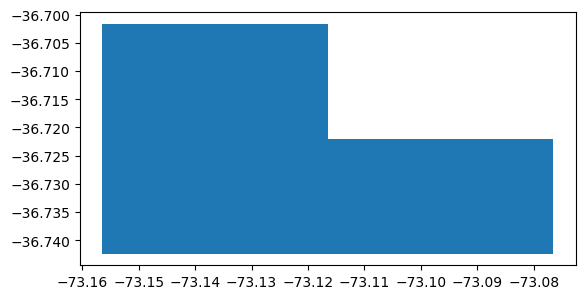

In [253]:
grid = gpd.GeoDataFrame({'geometry':geoms})
geoms

image_paths = []
ID = []
index = 1
for sq in geoms:
  xx, yy = sq.exterior.coords.xy
  x = xx.tolist()
  y = yy.tolist()

  url, direccion_imagen = descargar_imagen_landsat8(list(zip(x,y)), "2018-01-01","2019-01-01", "True Color",'./subimagenes', index)
  
  image_paths.append(direccion_imagen)
  ID.append(index)
  print(f"Imagen {index}: {url}")
  index = index + 1

grid.plot();
#image_paths


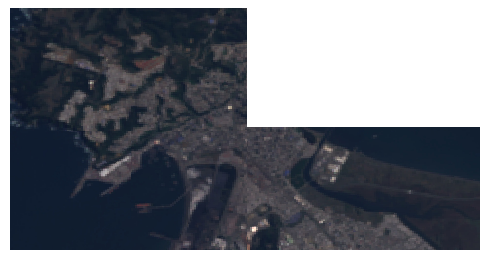

In [256]:



gdf = gpd.GeoDataFrame({'ID':ID,'geometry':geoms,  'image_path': image_paths})

# Cargar las imágenes en una lista
images = [plt.imread(image_path) for image_path in gdf['image_path']]

# Crear el gráfico de GeoDataFrame
fig, ax = plt.subplots(figsize=(6, 6))
gdf.boundary.plot(ax=ax, alpha=0.1)  # Dibujar los límites de los polígonos

# Iterar a través de los polígonos y agregar imágenes con zoom relativo al tamaño del gráfico
for polygon, image in zip(gdf.geometry, images):
    x, y = polygon.exterior.xy
    
    # Calcular el centroide del polígono
    centroid_x, centroid_y = polygon.centroid.xy
    
    # Calcular el zoom en función del tamaño del gráfico
    transform = ax.transData.transform  # Transformación de coordenadas de datos a figura
    zoom_x = (transform((max(x), max(y)))[0] - transform((min(x), min(y)))[0]) / (fig.get_figwidth() * 100)  # Ajusta el factor 125 según sea necesario
    zoom_y = (transform((max(x), max(y)))[1] - transform((min(x), min(y)))[1]) / (fig.get_figheight() * 100)  # Ajusta el factor 125 según sea necesario
    
    # Usar el zoom mínimo para no distorsionar la imagen
    zoom = min(zoom_x, zoom_y)
    
    imagebox = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(imagebox, (centroid_x[0], centroid_y[0]), frameon=False, pad=0)
    ax.add_artist(ab)

ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])
ax.set_axis_off()
plt.savefig('figura.jpg', dpi=300, bbox_inches='tight')

plt.show()
